In [1]:
library(tidyverse)
library(jsonlite)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




# Data Munging (for GPS and Weather)

In [2]:
gps_raw <- list()
for (file in list.files('gps')) {
    gps_raw[[file]] <- fromJSON(paste('gps/', file, sep=''), simplifyVector=TRUE)
}

In [3]:
# now pull out the coordinates
coords <- map(gps_raw, function (data) {t(simplify2array(data$features$geometry$coordinates))})

In [4]:
days_dfs <- map(names(gps_raw), function(name) {
    data.frame(time =strptime(gps_raw[[name]]$features$properties$time,format = "%Y-%m-%dT%H:%M:%S"),
               longitude = coords[[name]][,1],
               latitude = coords[[name]][,2])
})
names(days_dfs) <- names(gps_raw)

In [38]:
head(days_dfs[[1]], 3)
tail(days_dfs[[11]], 2)

,time,longitude,latitude
,<dttm>,<dbl>,<dbl>
1,2020-08-18 17:50:42,-114.0003,46.88678
2,2020-08-18 17:50:40,-114.0005,46.88632
3,2020-08-18 17:51:49,-113.9999,46.88604


,time,longitude,latitude
,<dttm>,<dbl>,<dbl>
866,2020-08-31 22:48:46,-114.0002,46.88728
867,2020-08-31 22:48:55,-114.0001,46.88740


### Process Weather Data

In [17]:
weather_raw <- fromJSON('historical_weather.json', simplifyVector=TRUE)
weather_obs <- weather_raw$observations
head(weather_obs)
colnames(weather_obs)
temperature_all <- weather_obs[, c('valid_time_gmt', 'min_temp')]

,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,⋯,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,⋯,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,KMSO,observation,1597740780,KMSO,Missoula,1597733580,N,70,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,KMSO,observation,1597744380,KMSO,Missoula,1597737180,N,76,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,KMSO,observation,1597747980,KMSO,Missoula,1597740780,N,71,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,KMSO,observation,1597751580,KMSO,Missoula,1597744380,N,71,29,2900,⋯,SCT,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,KMSO,observation,1597755180,KMSO,Missoula,1597747980,N,69,33,3300,⋯,FEW,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,KMSO,observation,1597758780,KMSO,Missoula,1597751580,N,65,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "key"                       "class"                    
 [3] "expire_time_gmt"           "obs_id"                   
 [5] "obs_name"                  "valid_time_gmt"           
 [7] "day_ind"                   "temp"                     
 [9] "wx_icon"                   "icon_extd"                
[11] "wx_phrase"                 "pressure_tend"            
[13] "pressure_desc"             "dewPt"                    
[15] "heat_index"                "rh"                       
[17] "pressure"                  "vis"                      
[19] "wc"                        "wdir"                     
[21] "wdir_cardinal"             "gust"                     
[23] "wspd"                      "max_temp"                 
[25] "min_temp"                  "precip_total"             
[27] "precip_hrly"               "snow_hrly"                
[29] "uv_desc"                   "feels_like"               
[31] "uv_index"                  "qualifier"                
[33] "qualifier_svrty"           "blunt_phrase"             
[35] "terse_phrase"              "clds"                     
[37] "water_temp"                "primary_wave_period"      
[39] "primary_wave_height"       "primary_swell_period"     
[41] "primary_swell_height"      "primary_swell_direction"  
[43] "secondary_swell_period"    "secondary_swell_height"   
[45] "secondary_swell_direction"

In [19]:
# verify observations are once every hour
temperature_all[2:6, 1] - temperature_all[1:5, 1]

[1] 3600 3600 3600 3600 3600

# Put Data Together & Explore

In [21]:
# now heap coordinates together with flag for their day
num_total <- sum(unlist(lapply(days_dfs, function(df) {return(dim(df)[1])})))
num_total
reduced_df <- data.frame(
    index=unlist(lapply(days_dfs, function(df) {return(1:length(df$time))})),
    time=unlist(lapply(days_dfs, function(df) {return(df$time)})),
    elapsed=unlist(lapply(days_dfs, function(df) {return(df$time - df$time[1])})),
    longitude=unlist(lapply(days_dfs, function(df) {return(df$longitude)})),
    latitude=unlist(lapply(days_dfs, function(df) {return(df$latitude)})),
    day=factor(unlist(lapply(1:length(days_dfs),
                                    function(idx) {return(rep(idx, length(days_dfs[[idx]]$longitude)))}
                                   )))
)

[1] 5857

In [31]:
# now pair data to temperature via linear interpolation
indices <- unlist(lapply(reduced_df$time, function(time) {which(temperature_all[, 1] > time)[1]}))
first_temp <- temperature_all[indices-1, 2]
second_temp <- temperature_all[indices, 2]
# now interpolate
diff <- temperature_all[indices, 1] - temperature_all[indices-1, 1]
weight <- (reduced_df$time - temperature_all[indices-1, 1])/diff
final_temps <- first_temp*weight + second_temp*(1-weight)

In [33]:
tail(temperature_all[, 1])
tail(reduced_df$time)

[1] 1598835180 1598838780 1598842380 1598845980 1598849580 1598853180

[1] 1598928492 1598928502 1598928510 1598928518 1598928526 1598928535

In [63]:
head(reduced_df)

,index,time,elapsed,longitude,latitude,day
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
20200818114606.geojson1,1,1597787442,0,-114.0003,46.88678,1
20200818114606.geojson2,2,1597787440,-2,-114.0005,46.88632,1
20200818114606.geojson3,3,1597787509,67,-113.9999,46.88604,1
20200818114606.geojson4,4,1597787544,102,-113.9992,46.88620,1
20200818114606.geojson5,5,1597787592,150,-113.9978,46.88587,1
20200818114606.geojson6,6,1597787591,149,-113.9972,46.88593,1


Warning message:
“Removed 114 rows containing missing values (geom_point).”


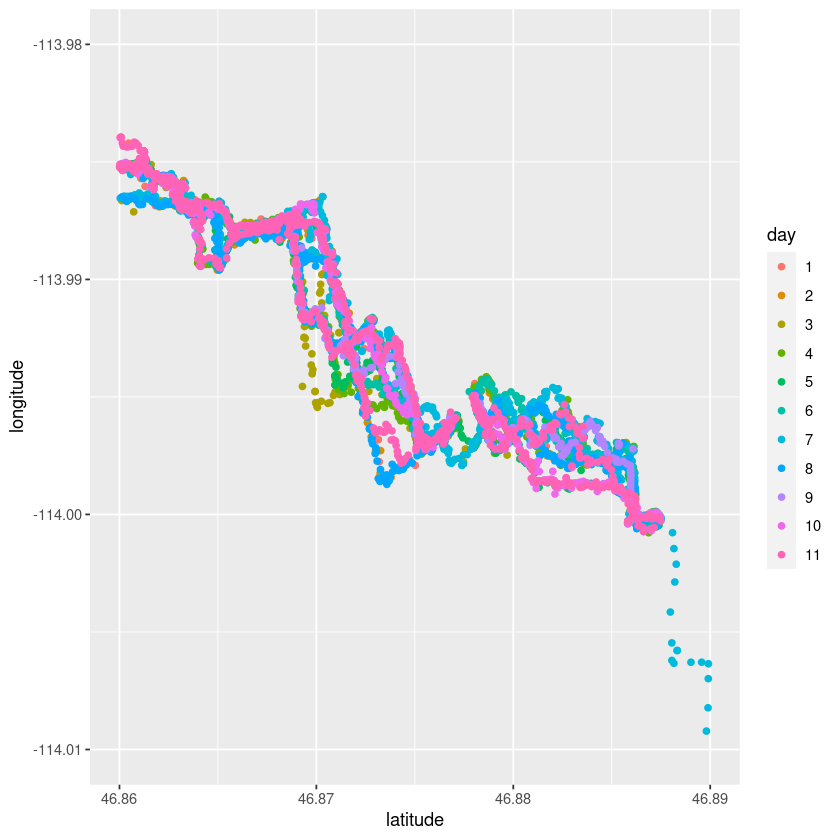

In [62]:
ggplot(reduced_df, aes(x=latitude, y=longitude, color=day)) +
    geom_point() +
    ylim(-114.01, -113.98) +
    xlim(46.86, 46.89)

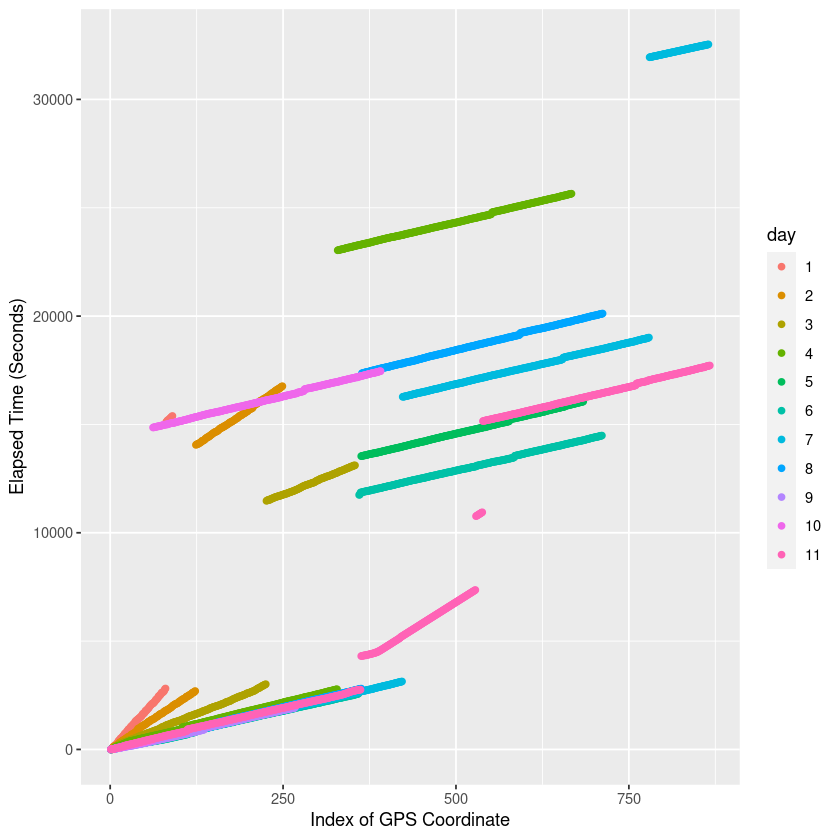

In [64]:
# now analyze in the time dimension
ggplot(reduced_df, aes(x=index, y=elapsed, color=day)) +
    geom_point() +
    ylab("Elapsed Time (Seconds)") +
    xlab("Index of GPS Coordinate")

In [33]:
length(days_dfs)

[1] 11